In [74]:
%matplotlib qt

import mne
import matplotlib.pyplot as plt
import sys
import os
import pathlib
import numpy as np
SCRIPT_DIR = pathlib.Path.cwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))

from continuous_control_bci.util import channel_names
mne.set_log_level('warning')



In [78]:
raw_calibration = mne.io.read_raw_gdf("../data/pilot_1/calibration/horse_reighns_pilot_driving.gdf",
                             preload=True)
channel_names
original_channel_names = [f"Channel {i + 1}" for i in range(32)] + [f"EX {i + 1}" for i in range(8)]
renaming = {original: new for original, new in zip(original_channel_names, channel_names)}

In [79]:
raw_calibration = raw_calibration.set_eeg_reference()
raw_calibration = raw_calibration.set_channel_types(dict.fromkeys(["EX 1", "EX 2", "EX 3", "EX 4"], "emg"))
raw_calibration = raw_calibration.set_channel_types(dict.fromkeys(["EX 5", "EX 6", "EX 7", "EX 8"], "eog"))
raw_calibration = raw_calibration.rename_channels(renaming)
raw_calibration = raw_calibration.set_montage("standard_1020", on_missing='raise')
raw_calibration = raw_calibration.set_eeg_reference()


In [80]:
raw_calibration

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


In [5]:
import pyxdf

fname = "../data/pilot_1/runs/full_run.xdf"
streams, header = pyxdf.load_xdf(fname)

for stream in streams: 
    print(stream['info']['name'])



['PredictionStream']
['BioSemi']


In [6]:
eeg_streams = streams[1]['time_series'].T
prediciton_stream = streams[0]["time_series"].T

In [7]:
raw_driving= mne.io.RawArray(eeg_streams[1:41, :] / 10e5, info=mne.create_info(channel_names, sfreq=2048))

In [147]:
eeg_mapping = {name: type for name, type in zip(channel_names[:-8], ["eeg"] * len(channel_names[:-8]))}
emg_mapping = {name: type for name, type in zip(channel_names[-8:-4], ["emg"] * 4)}
eog_mapping = {name: type for name, type in zip(channel_names[-4:], ["eog"] * 4)}



channel_type_mapping = {
    **eeg_mapping,
    **emg_mapping,
    **eog_mapping,
}
raw_driving.set_channel_types(channel_type_mapping)
raw_driving.set_montage("biosemi32", on_missing='raise')


ValueError: This channel name (Cz) doesn't exist in info.

In [9]:
print(raw_driving.get_data().min())
print(raw_calibration.get_data().min()) # These should be in the same ballpark. If one of them is 1e6 different from the other there's something wrong. 

-0.015628937631845474
-0.0183813875


In [10]:
for raw in [raw_driving, raw_calibration]:
    raw.set_eeg_reference(['Cz']).drop_channels(['Cz'])

In [11]:
prediction_timestamps = streams[0]['time_stamps']
prediction_values = streams[0]['time_series']

print(prediction_timestamps.shape)
print(prediction_values[:, 0].shape)
driving_emg_events = np.stack([(prediction_timestamps - streams[1]['time_stamps'][0])*2048, np.zeros(prediction_timestamps.shape), prediction_values[:, 0]]).T

(3733,)
(3733,)


In [12]:
import pickle
import scipy
import itertools

def make_precise_emg_events(raw, interval=0.05, epoch_time=0.2):
    with open('../data/pilot_1/emg_model.pkl', 'rb') as f:
        emg_model = pickle.load(f)

    raw_emg = raw.copy().pick(['emg'])

    filters = [
        mne.filter.create_filter(raw_emg.get_data(), l_freq=30, h_freq=500, method='iir',
                                 phase='forward', sfreq=raw.info['sfreq']),
        mne.filter.create_filter(raw_emg.get_data(), l_freq=51, h_freq=49, method='iir',
                                 phase='forward', sfreq=raw.info['sfreq']),
    ]
    # We do this strange to make is causal filters, in line with the model
    raw_data = scipy.signal.sosfilt(filters[0]['sos'],  raw_emg.get_data())
    raw_data = scipy.signal.sosfilt(filters[1]['sos'],  raw_data)
    raw_emg = mne.io.RawArray(raw_data, raw_emg.info)

    # Extract samples to classify
    emg_fine_epochs = mne.make_fixed_length_epochs(
        raw_emg,
        duration=epoch_time,
        overlap=epoch_time - interval,
        reject_by_annotation=False,
    )

    # Make predictions and remap
    emg_fine_preds = emg_model.predict(np.abs(emg_fine_epochs.get_data()).mean(axis=2))
    emg_fine_preds[emg_fine_preds==0] = -1.0
    emg_fine_preds[emg_fine_preds==2] = 0.0
    emg_fine_preds[emg_fine_preds==1] = 1.0
        
    timestamps = np.arange(0, len(raw_emg.times) - epoch_time*2048 , interval * 2048)
    timestamps = timestamps + (epoch_time - interval) * 2048

    all_pred_events = np.stack([timestamps, np.zeros(emg_fine_preds.shape), emg_fine_preds]).T.astype('int32')

    bits = emg_fine_preds
    index = 0
    starting_point_events = []
    for bit, group in itertools.groupby(bits):
        length = len(list(group))
        if length * interval >= 3.75:
            starting_point_events.append(all_pred_events[index, :])
            print(f"{length  * interval} seconds of {all_pred_events[index, 2]}")
        index += length
    
    # So at the start 
    starting_point_events = np.array(starting_point_events).astype('int32')
    starting_point_events[:, 0] = starting_point_events[:, 0] 

    return starting_point_events

driving_events = make_precise_emg_events(raw_driving)


17.1 seconds of 0
9.600000000000001 seconds of 1
4.25 seconds of 1
8.35 seconds of 1
6.45 seconds of -1
9.200000000000001 seconds of 1
10.25 seconds of -1
4.0 seconds of 1
5.4 seconds of -1
8.85 seconds of -1
7.8500000000000005 seconds of 1
3.95 seconds of 0
6.95 seconds of 1
10.3 seconds of -1
3.85 seconds of -1
9.0 seconds of -1
10.0 seconds of 1
6.800000000000001 seconds of -1
7.7 seconds of -1
10.450000000000001 seconds of 1
11.600000000000001 seconds of -1
5.15 seconds of 1
7.4 seconds of -1
6.95 seconds of -1
9.35 seconds of 1
9.65 seconds of 1
13.200000000000001 seconds of -1
4.45 seconds of -1
8.25 seconds of -1
10.0 seconds of 1
8.200000000000001 seconds of -1
9.450000000000001 seconds of -1
9.850000000000001 seconds of 1
10.950000000000001 seconds of -1
5.95 seconds of 1
4.3500000000000005 seconds of -1
10.450000000000001 seconds of -1
9.15 seconds of 1
7.8500000000000005 seconds of 1
12.55 seconds of -1
4.95 seconds of -1
3.8000000000000003 seconds of 1
8.1 seconds of -1
9.6

In [13]:
driving_epochs = mne.Epochs(
        raw_driving,
        driving_events,
        event_id=dict(left=-1, rest=0, right=1),
        tmin=0,
        tmax=3.75,
        baseline=None,
        preload=True,
        reject_by_annotation=False
    )
driving_epochs


Number of events,64
Events,left: 34rest: 2right: 28
Time range,0.000 – 3.750 s
Baseline,off


In [14]:
from continuous_control_bci.data.preprocessing import make_epochs
calibration_epochs = make_epochs(raw_calibration)
calibration_epochs.shift_time(-2.25)

/Users/ivopascal/Documents/PhD/continuous_control_bci/continuous_control_bci/data/preprocessing.py:69: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
/Users/ivopascal/Documents/PhD/continuous_control_bci/continuous_control_bci/data/preprocessing.py:69: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Number of events,80
Events,left: 20rest: 40right: 20
Time range,0.000 – 3.750 s
Baseline,off


In [15]:
all_epochs = {"driving": driving_epochs, "calibration": calibration_epochs}

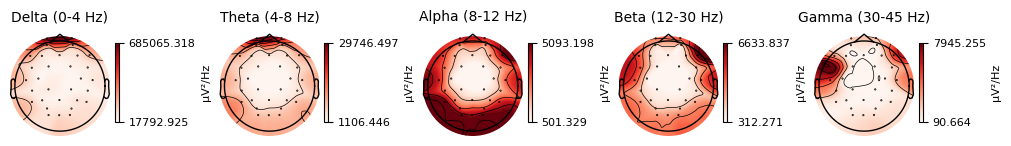

In [16]:
calibration_epochs['left'].compute_psd().plot_topomap()

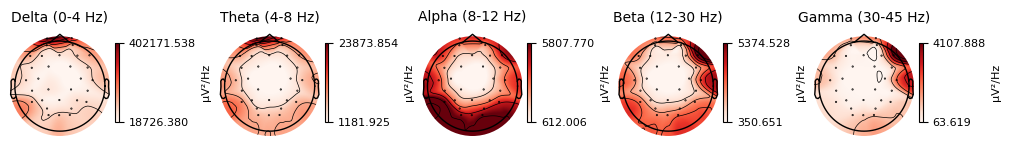

In [17]:
calibration_epochs['right'].compute_psd().plot_topomap()

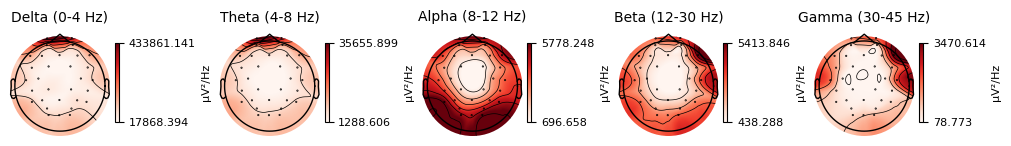

In [18]:
calibration_epochs['rest'].compute_psd().plot_topomap()

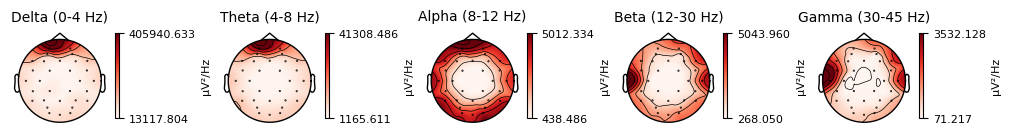

In [19]:
driving_epochs['left'].compute_psd().plot_topomap() # But this is also just very strange. The lower bound drops to the 100s instead of 1000s. 

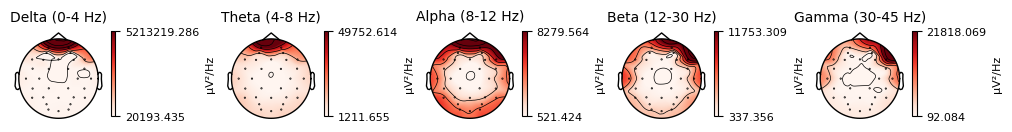

In [20]:
driving_epochs['right'].compute_psd().plot_topomap()

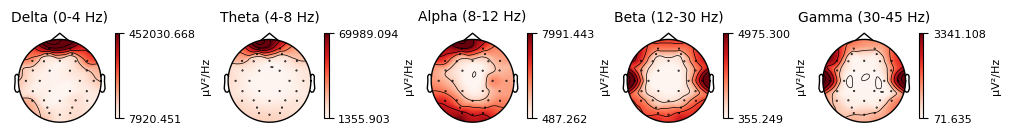

In [21]:
driving_epochs['rest'].compute_psd().plot_topomap()

In [51]:
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper

driving_epochs = mne.Epochs(
        raw_driving,
        driving_events,
        event_id=dict(left=-1, rest=0, right=1),
        tmin=-2.5,
        tmax=3.75 + 0.5,
        baseline=None,
        picks=("C3", "C4"),
        preload=True,
        reject_by_annotation=False
    )
driving_epochs




Number of events,62
Events,left: 34rest: 1right: 27
Time range,-2.500 – 4.250 s
Baseline,off


In [108]:

def plot_tfr(epochs, baseline=(-2, -1), tmin=-2, tmax=3.75, event_ids=dict(left=-1, rest=0, right=1)):
    freqs = np.arange(10, 30)  # frequencies from 2-35Hz
    vmin, vmax = -1, 2  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
    kwargs = dict(
        n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
    )  # for cluster test

    
    tfr = tfr_multitaper(
        epochs,
        freqs=freqs,
        n_cycles=freqs,
        use_fft=True,
        return_itc=False,
        average=False,
        decim=2,
    )
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
    
    for event in event_ids:
        # select desired epochs for visualization
        tfr_ev = tfr[event]
        fig, axes = plt.subplots(
            1, 3, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 1]}
        )
        for ch, ax in enumerate(axes[:-1]):  # for each channel
            # positive clusters
            _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
            # negative clusters
            _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)
    
            # note that we keep clusters with p <= 0.05 from the combined clusters
            # of two independent tests; in this example, we do not correct for
            # these two comparisons
            c = np.stack(c1 + c2, axis=2)  # combined clusters
            p = np.concatenate((p1, p2))  # combined p-values
            mask = c[..., p <= 0.05].any(axis=-1)
    
            # # plot TFR (ERDS map with masking)
            tfr_ev.average().plot(
                [ch],
                cmap="RdBu_r",
                cnorm=cnorm,
                axes=ax,
                colorbar=False,
                show=False,
                mask=mask,
                mask_style="mask",
            )
    
            ax.set_title(epochs.ch_names[ch], fontsize=10)
            ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
            if ch != 0:
                ax.set_ylabel("")
                ax.set_yticklabels("")
        fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
        fig.suptitle(f"ERDS ({event})")
        plt.show()



In [72]:
plot_tfr(driving_epochs, event_ids=dict(left=-1, right=1))


In [73]:
plot_tfr(calibration_epochs, event_ids=dict(left=-1, right=1))

qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f32c40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f3dfe0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f58780> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 2 doesn't match <NSViewBackingLayer: 0x600000f32c40> contents scale of 1 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f3dfe0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f58780> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 2 doesn't match <NSViewBackingLayer: 0x600000f32c40> contents scale of 1 - updating layer to match.
qt.qpa.backingstore:

In [49]:

LEFT_HAND_EVENT = "769"
RIGHT_HAND_EVENT = "770"
END_OF_TRIAL_EVENT = "800"  # Used for rests

calibration_events, _ = mne.events_from_annotations(raw_calibration, event_id={LEFT_HAND_EVENT: 0,
                                                           RIGHT_HAND_EVENT: 1})
# Now we'd expect the movement 1 + 1.25 = 2.25 seconds in. The exact timing may be learned
# It should stay until 6 seconds in. The first and last second should both be "empty"
# These would be the optimal "during movement" timings. For visualisation, you might also consider
# preparation or rebound effects.
tmin = 2.25
tmax = 2.25 + 3.75

event_ids = dict(left=0, right=1)

calibration_epochs = mne.Epochs(
    raw_calibration,
    calibration_events,
    event_ids,
    tmin - 2.5,
    tmax + 0.5,
    baseline=None,
    preload=True,
)

# For rest we want to have 0.25s buffer after end of movement
# But we do want to keep the same time span
# This is okay because after END_OF_TRIAL there is
# [1.5, 3.5] seconds of black screen
# 3 seconds of cross
# This means tmax cannot be larger than 4.5
# We take tmin = 0.5, so tmax ends at 4.25
tmin = 0.5
tmax = 0.5 + 3.75
assert tmax < 4.5
calibration_events, _ = mne.events_from_annotations(raw, event_id={
    END_OF_TRIAL_EVENT: 2
})
rest_epochs = mne.Epochs(
    raw_calibration,
    calibration_events,
    dict(rest=2),
    tmin-2.5,
    tmax + 0.5,
    baseline=None,
    preload=True,
)
rest_epochs.shift_time(2.25 - 0.5)  # This only changes the metadata time. The data stays the same

calibration_epochs = mne.concatenate_epochs([calibration_epochs, rest_epochs], add_offset=False)
calibration_epochs.shift_time(-2.25).pick(picks=("C3", "C4"))

/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_44432/3826142206.py:50: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  calibration_epochs = mne.concatenate_epochs([calibration_epochs, rest_epochs], add_offset=False)
/var/folders/lm/ht2dkcld0tn4b4c0hqznvyfr0000gn/T/ipykernel_44432/3826142206.py:50: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  calibration_epochs = mne.concatenate_epochs([calibration_epochs, rest_epochs], add_offset=False)


Number of events,80
Events,left: 20rest: 40right: 20
Time range,-2.500 – 4.250 s
Baseline,off


In [82]:
raw_calibration_erds = raw_calibration.copy().filter(l_freq=1, h_freq=30)

In [86]:
from mne.preprocessing import ICA
ica = ICA(random_state=42)
ica.fit(raw_calibration_erds)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,103 iterations on raw data (882656 samples)
ICA components,31
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


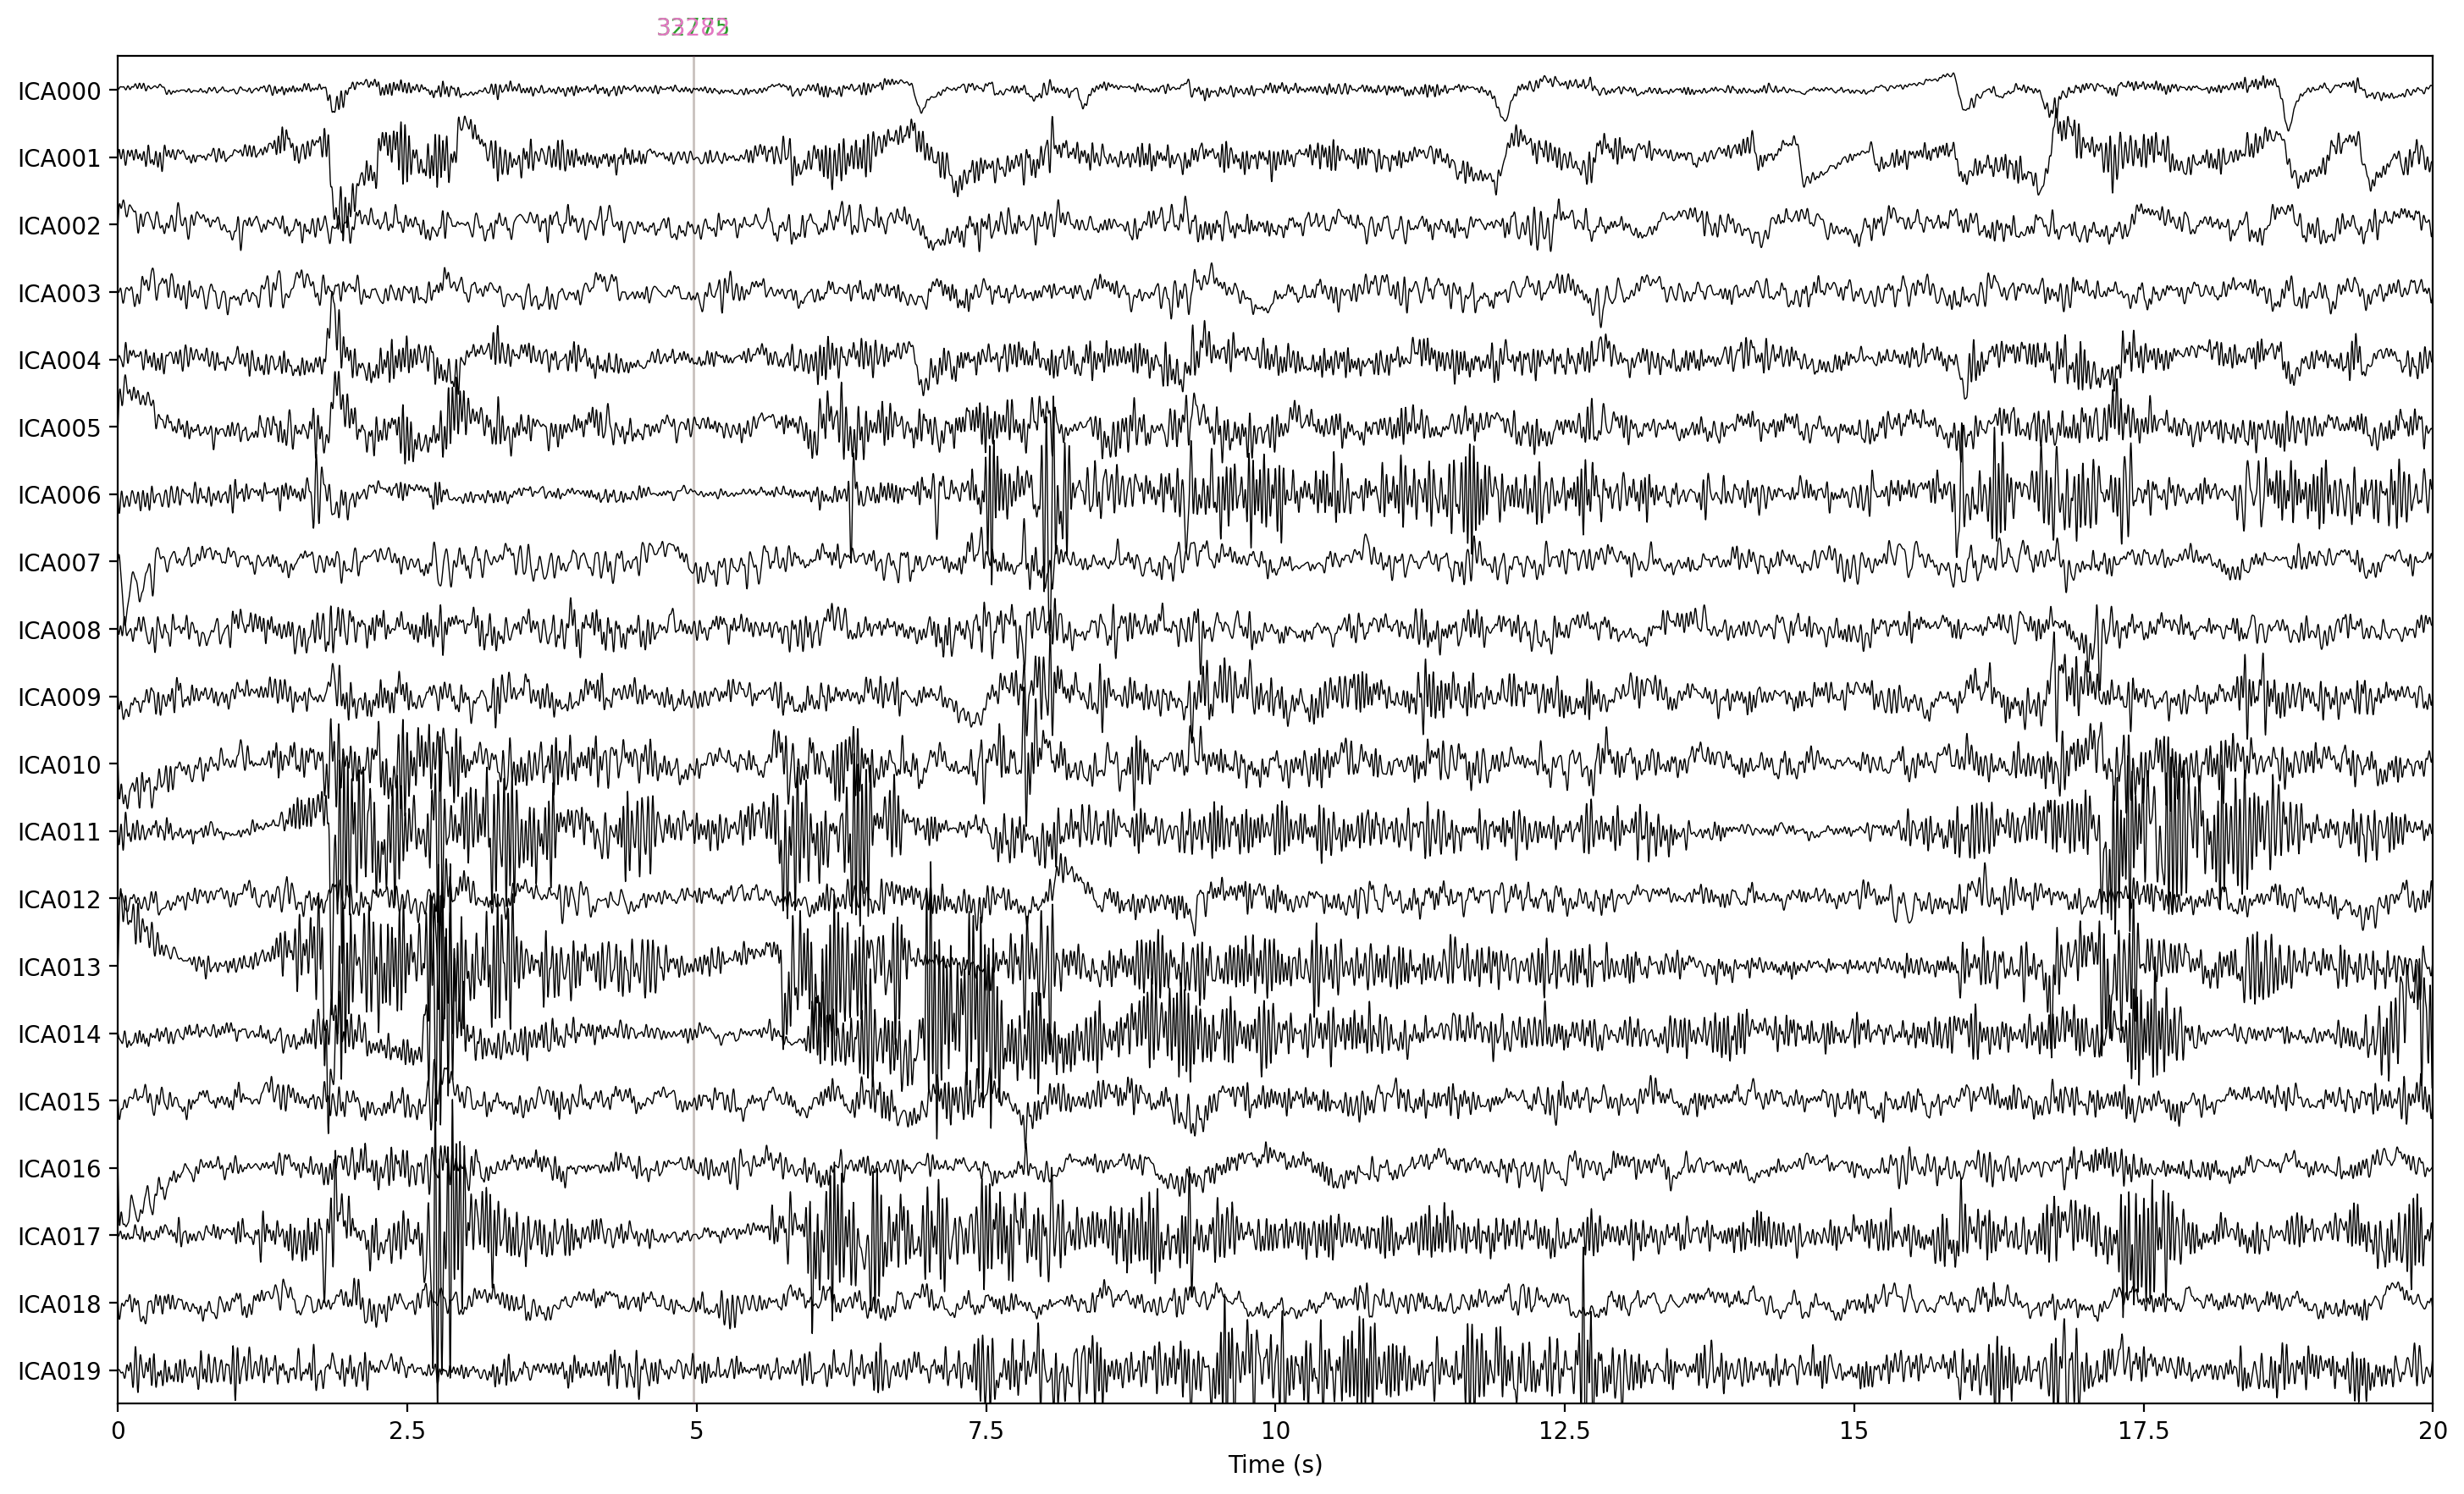

qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f3dfe0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f40e40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f58780> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 2 doesn't match <NSViewBackingLayer: 0x600000f58780> contents scale of 1 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f3dfe0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f40e40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 2 doesn't match <NSViewBackingLayer: 0x600000f40e40> contents scale of 1 - updating layer to match.


In [91]:
ica.plot_sources(raw_calibration_erds, show_scrollbars=False)

In [90]:
ica.find_bads_eog(raw_calibration_erds)

([0, 1, 5],
 [array([-2.77768677e-01,  8.32506353e-01,  7.09073498e-02, -1.22120009e-01,
          1.39722493e-01, -6.55119519e-02, -3.13742982e-02, -1.96705291e-02,
          7.05875921e-02,  7.95592112e-02,  7.70281786e-02,  6.43609716e-02,
          3.42519875e-03,  1.51242693e-02, -1.00778669e-01, -6.39984870e-02,
         -5.67863057e-02, -7.03212598e-02, -4.65570199e-04, -5.10025869e-02,
          1.51025091e-02, -1.90135370e-02,  1.74033394e-03,  1.08726265e-03,
         -3.10547238e-02,  2.92334561e-02, -4.96390076e-02,  5.19706855e-02,
         -5.26087978e-02,  6.02748299e-04, -5.07442773e-02]),
  array([ 0.12363429, -0.79791148,  0.1217339 , -0.07881652, -0.09470928,
         -0.28075331,  0.17330713, -0.08798991, -0.03821129, -0.02986716,
         -0.01210837,  0.01978525, -0.02933685, -0.01309335,  0.0114333 ,
         -0.13132274, -0.01218212, -0.1762796 ,  0.02790253,  0.04005649,
          0.00805683,  0.02066189,  0.02200921,  0.01540115, -0.04172575,
          0.03097

qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f3dfe0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f40e40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f58780> contents scale of 2 - updating layer to match.


In [89]:
raw_calibration_erds

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,1.00 Hz
Lowpass,30.00 Hz


In [92]:
ica.plot_components()

[<MNEFigure size 1950x1832 with 20 Axes>,
 <MNEFigure size 1950x1462 with 11 Axes>]

qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f3dfe0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x600000f3dfe0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 2 doesn't match <NSViewBackingLayer: 0x600000f3dfe0> contents scale of 1 - updating layer to match.


In [97]:
ica

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,103 iterations on raw data (882656 samples)
ICA components,31
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,ICA000ICA001ICA002ICA004ICA006ICA008ICA010ICA011ICA014ICA017ICA019ICA022ICA023ICA005


In [98]:
ica.apply(raw_calibration_erds)

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,1.00 Hz
Lowpass,30.00 Hz


In [103]:
raw_calibration_erds = mne.preprocessing.compute_current_source_density(raw_calibration_erds)

In [104]:
raw_calibration_erds

Measurement date,Unknown
Experimenter,Unknown
Participant,0x00000000
Digitized points,35 points
Good channels,"32 Current source density, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,1.00 Hz
Lowpass,30.00 Hz


In [144]:
LEFT_HAND_EVENT = "769"
RIGHT_HAND_EVENT = "770"
END_OF_TRIAL_EVENT = "800"  # Used for rests

calibration_events, _ = mne.events_from_annotations(raw_calibration_erds, event_id={LEFT_HAND_EVENT: 0,
                                                           RIGHT_HAND_EVENT: 1})
# Now we'd expect the movement 1 + 1.25 = 2.25 seconds in. The exact timing may be learned
# It should stay until 6 seconds in. The first and last second should both be "empty"
# These would be the optimal "during movement" timings. For visualisation, you might also consider
# preparation or rebound effects.
tmin = -3
tmax = 1.25 + 3.75

event_ids = dict(left=0, right=1)

calibration_epochs = mne.Epochs(
    raw_calibration_erds,
    calibration_events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    baseline=None,
    picks=['C3', 'C4'],
    preload=True,
)

In [146]:
def plot_tfr(epochs, baseline=(-2, -1), tmin=-2, tmax=3.75, event_ids=dict(left=-1, rest=0, right=1)):
    freqs = np.arange(10, 30)  # frequencies from 2-35Hz
    vmin, vmax = -1, 1  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
    kwargs = dict(
        n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
    )  # for cluster test

    
    tfr = tfr_multitaper(
        epochs,
        freqs=freqs,
        n_cycles=freqs,
        use_fft=True,
        return_itc=False,
        average=False,
        decim=2,
    )
    tfr.crop(tmin, tmax)
    if baseline is not None:
        tfr.apply_baseline(baseline, mode="percent")
    
    for event in event_ids:
        # select desired epochs for visualization
        tfr_ev = tfr[event]
        fig, axes = plt.subplots(
            1, 3, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 1]}
        )
        for ch, ax in enumerate(axes[:-1]):  # for each channel
            if baseline is not None:
                # positive clusters
                _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
                # negative clusters
                _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)
        
                # note that we keep clusters with p <= 0.05 from the combined clusters
                # of two independent tests; in this example, we do not correct for
                # these two comparisons
                c = np.stack(c1 + c2, axis=2)  # combined clusters
                p = np.concatenate((p1, p2))  # combined p-values
                mask = c[..., p <= 0.01].any(axis=-1)
        
                # plot TFR (ERDS map with masking)
                tfr_ev.average().plot(
                    [ch],
                    cmap="RdBu_r",
                    cnorm=cnorm,
                    axes=ax,
                    colorbar=False,
                    show=False,
                    mask=mask,
                    mask_style="mask",
                )
            else:
                tfr_ev.average().plot(
                    [ch],
                    cmap="RdBu_r",
                    axes=ax,
                    colorbar=False,
                )
    
            ax.set_title(epochs.ch_names[ch], fontsize=10)
            ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
            if ch != 0:
                ax.set_ylabel("")
                ax.set_yticklabels("")
        fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
        fig.suptitle(f"ERDS ({event})")
        plt.show()


plot_tfr(calibration_epochs, baseline=(-3, 0), tmin=tmin, tmax=tmax, event_ids=event_ids)
plot_tfr(calibration_epochs, baseline=None, tmin=tmin, tmax=tmax, event_ids=event_ids)

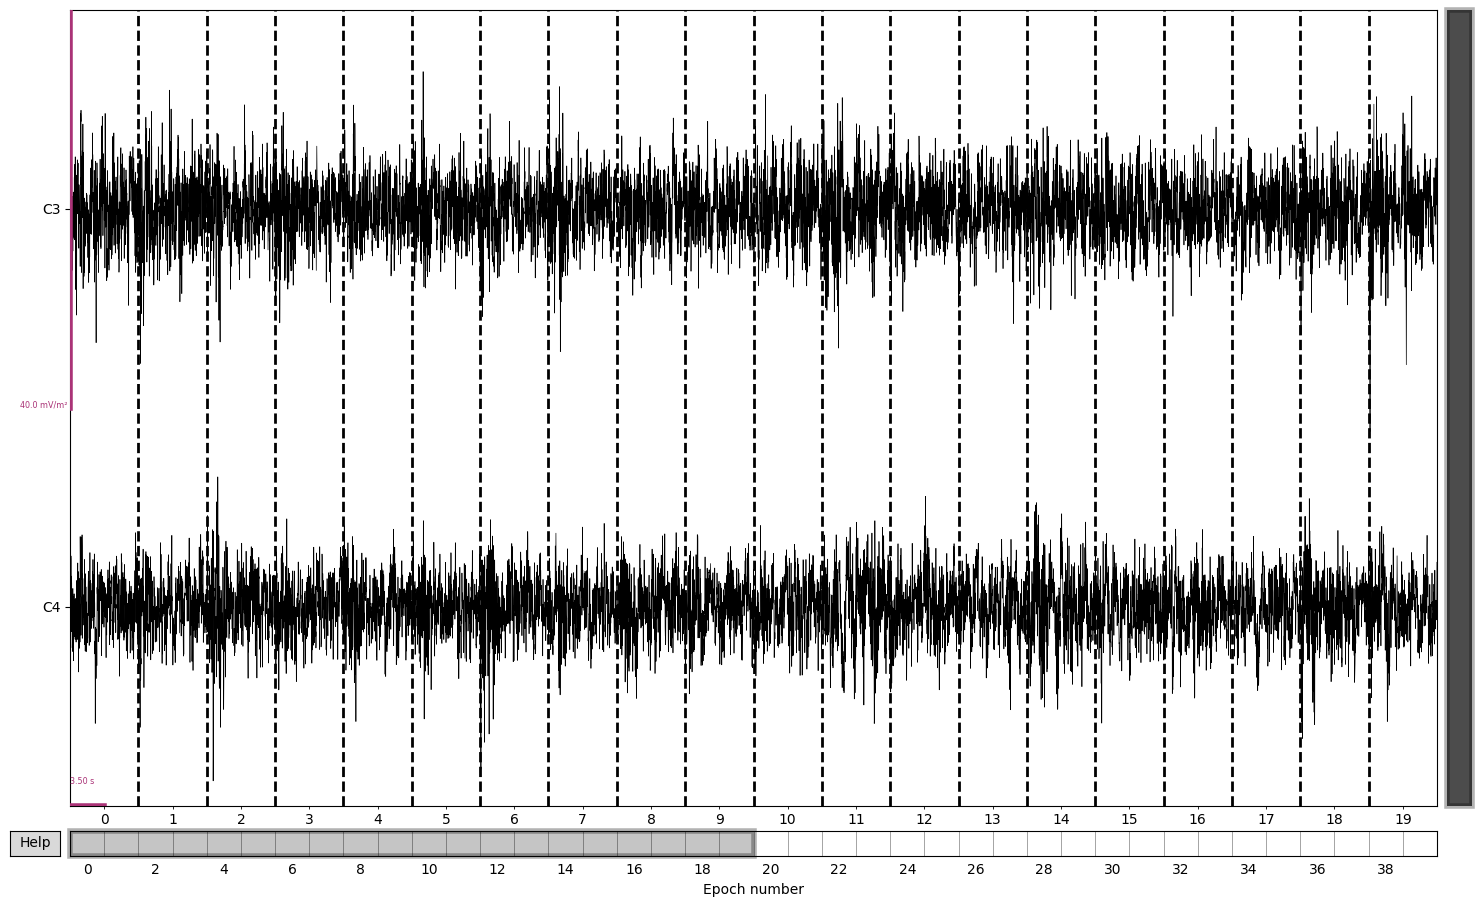

In [118]:
calibration_epochs.plot()

In [124]:

calibration_epochs = mne.Epochs(
    raw_calibration_erds,
    calibration_events,
    event_ids,
    tmin=2,# - 2.25 - 0.5,
    tmax,# + 0.5,
    baseline=None,
    # picks=['C3', 'C4'],
    preload=True,
).copy().compute_psd().plot_topomap()

